In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import time

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
with open("../input/monkeyspikes/training_arm.pickle", "rb") as f:
    training_arm = pickle.load(f)

with open("../input/monkey-stacking/output_models.pickle", "rb") as f:
    output_models = pickle.load(f)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
BATCH_SIZE = 24

X_train, X_test, y_train, y_test = train_test_split(
    output_models, training_arm,
    test_size=0.3, random_state=2022
)

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
X, y = next(iter(train_dataloader))
print(X.shape)
print(y.shape)

torch.Size([24, 6001])
torch.Size([24, 3000])


In [6]:
class NNStacker(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 5_000),
            nn.ReLU(),
            nn.Linear(5_000, 4_000),
            nn.ReLU(),
            nn.Linear(4_000, output_size)
        )

    def forward(self, x):
        out = self.main(x)
        return out


def trainer(model, criterion, optimizer, trainloader, validloader, epochs=15, verbose=True):
    """Simple training wrapper for PyTorch network."""

    train_loss = []
    valid_loss = []
    for epoch in range(epochs):
        losses = 0
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Clear gradients w.r.t. parameters
            y_hat = model(X.reshape(X.shape[0], -1))
            loss = criterion(y_hat, y)  # Calculate loss
            loss.backward()             # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            losses += loss.item()       # Add loss for this batch to running total
        train_loss.append(losses / len(trainloader))

        # Validation
        model.eval()
        valid_losses = 0
        with torch.no_grad():
            for X, y in validloader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                valid_losses += loss.item()
        valid_loss.append(valid_losses / len(validloader))
        
        model.train()

        if verbose:
            print(f"Epoch: {epoch + 1}, "
                  f"Train loss: {losses / len(trainloader):.2f}, "
                  f"Valid loss: {valid_losses / len(validloader):.2f}")

    results = {"train_loss": train_loss,
               "valid_loss": valid_loss}
    return results

In [7]:
torch.manual_seed(2022)

model = NNStacker(input_size=6_001, output_size=3_000)
model.to(device);

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-5)

print(time.strftime("%H:%M:%S", time.localtime()))
trainer(model, criterion, optimizer, train_dataloader, valid_dataloader, verbose=True)
print(time.strftime("%H:%M:%S", time.localtime()))

09:27:16
Epoch: 1, Train loss: 711.34, Valid loss: 769.81
Epoch: 2, Train loss: 662.42, Valid loss: 802.92
Epoch: 3, Train loss: 659.67, Valid loss: 783.70
Epoch: 4, Train loss: 655.28, Valid loss: 771.93
Epoch: 5, Train loss: 654.79, Valid loss: 768.26
Epoch: 6, Train loss: 656.59, Valid loss: 790.24
Epoch: 7, Train loss: 657.49, Valid loss: 770.27
Epoch: 8, Train loss: 659.03, Valid loss: 775.30
Epoch: 9, Train loss: 659.72, Valid loss: 768.69
Epoch: 10, Train loss: 659.59, Valid loss: 776.33
Epoch: 11, Train loss: 659.30, Valid loss: 761.11
Epoch: 12, Train loss: 660.21, Valid loss: 780.18
Epoch: 13, Train loss: 659.54, Valid loss: 795.15
Epoch: 14, Train loss: 659.88, Valid loss: 789.95
Epoch: 15, Train loss: 659.14, Valid loss: 755.89
09:31:51


In [8]:
y_hat = model(torch.Tensor(X_test).to(device))
y_hat = y_hat.cpu().detach().numpy()

rmse = np.sqrt(np.mean((y_test - y_hat)**2))
print(rmse)

27.493529017068873


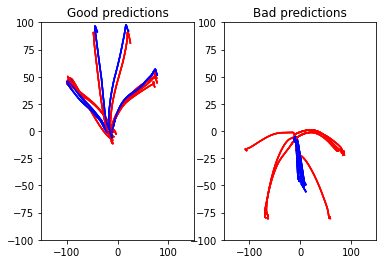

In [9]:
good_examples = 0
bad_examples = 0

ax_good = plt.subplot(121)
ax_bad = plt.subplot(122)

for X, y in valid_dataloader:
    X, y = X.to(device), y.to(device)
    prediction = model(X)

    y = y.cpu().detach().numpy()
    prediction = prediction.cpu().detach().numpy()
    
    while good_examples < 30 and bad_examples < 30:
        for i in range(X.shape[0]):
            rmse = np.sqrt(np.mean((prediction[i, :] - y[i, :])**2))
            if rmse < 5:
                good_examples += 1
                ax_good.plot(y[i, :1000], y[i, 1000:2000], color="r")
                ax_good.plot(prediction[i, :1000], prediction[i, 1000:2000], color="b")
            if rmse > 30:
                bad_examples += 1
                ax_bad.plot(y[i, :1000], y[i, 1000:2000], color="r")
                ax_bad.plot(prediction[i, :1000], prediction[i, 1000:2000], color="b")

ax_good.title.set_text("Good predictions")
ax_bad.title.set_text("Bad predictions")
ax_good.set_xlim([-150, 150])
ax_good.set_ylim([-100, 100])
ax_bad.set_xlim([-150, 150])
ax_bad.set_ylim([-100, 100])
plt.show()